In [3]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import os
import seaborn as sns
import matplotlib.pyplot as plt
from essentials import resample_data, add_labels
from extract_features import GenerateFeatures
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder



In [4]:
with open('data/df_dict_imu.pkl', 'rb') as f:
    imu_dict = pickle.load(f)
with open('data/df_minze_dict.pkl', 'rb') as f:
    ground_truth_dict = pickle.load(f)
with open('data/df_dict_urineestimate_method1.pkl', 'rb') as f:
    urine_estimate_dict = pickle.load(f)
    


Remove the data with the almost the entire data being void.
1. subj_9_void4
2. subj_11_void2

In [5]:
del imu_dict['subj_9_void4']
del imu_dict['subj_11_void2']

Resample the data

In [6]:
resampled_imu_dict = resample_data(imu_dict, 70)

41it [00:00, 833.86it/s]


Add the labels

In [7]:
labelled_imu_dict = {}
for i_void_instance, void_instance in tqdm(enumerate(resampled_imu_dict.keys()), desc="Adding labels to IMU data"):
    acc = resampled_imu_dict[void_instance]
    gt = ground_truth_dict[void_instance]
    
    labelled_imu_dict[void_instance] = add_labels(acc, gt)

Adding labels to IMU data: 41it [00:00, 738.09it/s]


Extract windowed features from the 3 axis of the accelerometer and the acceleration magnitude.
1. mean
2. rms
3. std
4. range
5. rms
6. variance
7. permutation entropy
8. spectral entropy

In [ ]:
all_features = []
for exp_id, imu_data in enumerate(labelled_imu_dict.keys()):    
    # Extract features
    analyzer = GenerateFeatures(fs=70, window_duration=1.0, overlap=0.8)
    features, _ = analyzer.analyze_multi_axis_imu(labelled_imu_dict[imu_data])

    table = analyzer.create_summary_table()
    table['experiment_id'] = exp_id + 1  # Track source
    all_features.append(table)
    

final_features = pd.concat(all_features, ignore_index=True)

Analyzing : 100%|██████████| 4/4 [00:00<00:00,  6.14it/s]


In [ ]:
final_features.to_csv('activity_features.csv', index=False)


In [23]:
features = pd.read_csv('/home/edumaba/Public/MPhil_Thesis/Code/uropatch-data-analysis/activity_features.csv')
features.drop(['center_time', 'start_time', 'end_time'], axis=1, inplace=True)
features.head()

,acc_x_permutation_entropy,acc_x_spectral_entropy,acc_x_mean,acc_x_std,acc_x_range,acc_x_rms,acc_x_var,acc_x_min,acc_x_max,acc_x_time_energy,...,acc_mag_std,acc_mag_range,acc_mag_rms,acc_mag_var,acc_mag_min,acc_mag_max,acc_mag_time_energy,acc_mag_spectral_energy,label,experiment_id
0,0.865372,0.499289,0.936305,1.137581,5.41962,1.473349,1.294090,-1.184994,4.234626,151.953041,...,0.952641,4.247046,1.995090,0.907525,0.168266,4.415312,278.626807,19503.876521,pre-void,1
1,0.816043,0.481647,0.989842,1.158399,5.41962,1.523704,1.341888,-1.184994,4.234626,162.517245,...,0.972284,4.247046,1.987835,0.945337,0.168266,4.415312,276.604259,19362.298164,pre-void,1
2,0.822487,0.536058,1.195631,1.187488,5.41962,1.685130,1.410128,-1.184994,4.234626,198.776356,...,1.028004,4.247046,2.171321,1.056792,0.168266,4.415312,330.024516,23101.716142,pre-void,1
3,0.792757,0.535459,1.251095,1.199598,5.41962,1.733284,1.439036,-1.184994,4.234626,210.299251,...,1.007495,4.247046,2.172495,1.015047,0.168266,4.415312,330.381288,23126.690133,pre-void,1
4,0.792624,0.544907,1.165332,1.209628,5.41962,1.679642,1.463199,-1.184994,4.234626,197.483830,...,1.079930,4.247046,2.106117,1.166249,0.168266,4.415312,310.501137,21735.079605,pre-void,1


View label distribution

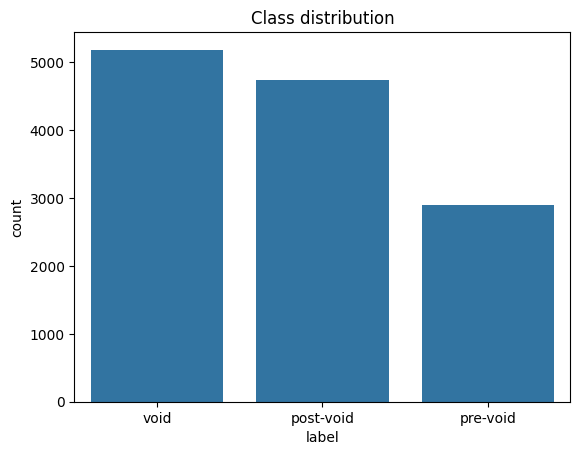

In [24]:
plt.figure()
sns.countplot(x = 'label',
              data = features,
              order = features.label.value_counts().index)
plt.title('Class distribution')
plt.show()

In [25]:
features.label.value_counts()

label
void         5185
post-void    4746
pre-void     2895
Name: count, dtype: int64

In [26]:
from sklearn.model_selection import GroupShuffleSplit

X = features.drop(columns=['label', 'experiment_id'])
y = features['label']
groups = features['experiment_id']

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [27]:
# Encode string labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


# Now train XGBoost
model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="multi:softprob",
    eval_metric='mlogloss',
    verbosity=0
)

eval_set = [(X_train, y_train_encoded), (X_test, y_test_encoded)]
model.fit(X_train, y_train_encoded, eval_set=eval_set, verbose=False)  # Use encoded labels

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [28]:
# Classification report
y_pred = label_encoder.inverse_transform(model.predict(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   post-void       0.53      0.52      0.53      1463
    pre-void       0.29      0.38      0.33       631
        void       0.59      0.53      0.56      1325

    accuracy                           0.50      3419
   macro avg       0.47      0.48      0.47      3419
weighted avg       0.51      0.50      0.50      3419



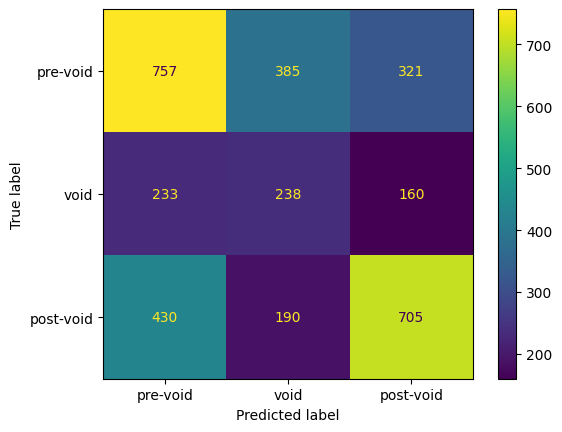

In [29]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['pre-void', 'void', 'post-void'])
cm_display.plot()
plt.show()

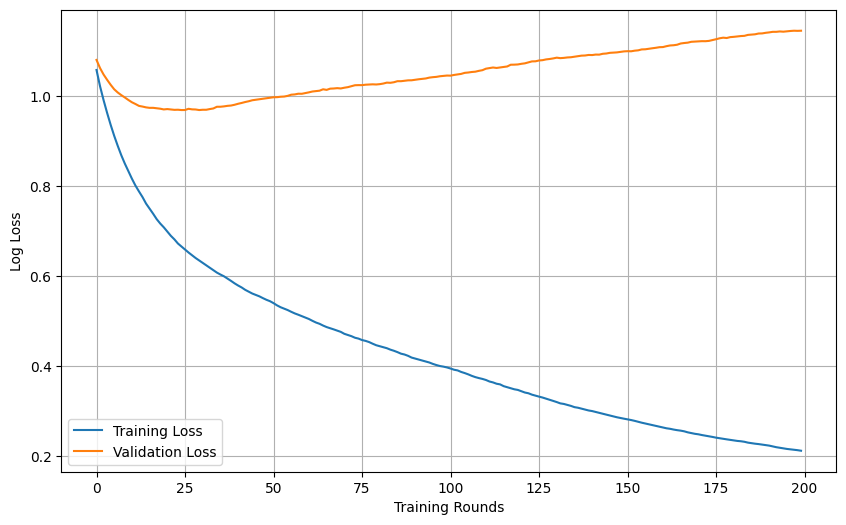

In [30]:
# Retrieve the evaluation results
results = model.evals_result()
train_loss = results['validation_0']['mlogloss']
test_loss = results['validation_1']['mlogloss']

# Plot the loss function
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Validation Loss')
plt.xlabel('Training Rounds')
plt.ylabel('Log Loss')
# plt.title('Loss')
plt.legend()
plt.grid(True)
plt.savefig('xgboost_loss_plot.png')